In [1]:
from main import convert_column_to_float, convert_column_to_int, convert_column_to_date, perform_agglomerative_clustering, perform_kmeans_clustering, log_transform

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import sqldf

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## load data

In [2]:
dvf = pd.read_csv('./data/dvf.csv', sep=',', low_memory=False)

query = """
select 
    id_mutation,
    date_mutation,
    valeur_fonciere,
    code_commune,
    adresse_code_voie,
    longitude,
    latitude,
    code_type_local,
    nombre_pieces_principales,
    code_nature_culture,
    nature_culture,
    surface_reelle_bati,
    surface_terrain
from dvf 
where id_mutation in (
    select id_mutation 
    from dvf 
    where code_type_local in (1, 2) 
    group by id_mutation 
    having count(distinct code_type_local) = 1
)
and nature_mutation in ('Vente', 'Adjudication', 'Echange')
and code_type_local in (1, 2, 3)
"""

# Run the query
dvf = sqldf.run(query)




In [3]:
# Houses and apartments
query = """
select distinct
    id_mutation,
    date_mutation,
    valeur_fonciere,
    code_commune,
    adresse_code_voie,
    longitude,
    latitude,
    code_type_local,
    nombre_pieces_principales,
    nature_culture,
    surface_reelle_bati,
    surface_terrain
from dvf 
where code_type_local in (1,2) and code_nature_culture in ('S', '')
"""
dvf_train = sqldf.run(query)
print("Transactions", dvf_train.shape)

# Extract the different available areas
# T : terres
# J : jardin
# AG: terrains d'agréments
# other

query = """
select dvf.id_mutation, sum(dvf_train.surface_terrain) as surface_terres
from dvf 
right join dvf_train on dvf.id_mutation = dvf_train.id_mutation
where 
    dvf.code_type_local = 3
    and dvf.code_nature_culture = 'T'
group by dvf.id_mutation
"""
dvf_train_terres = sqldf.run(query)

query = """
select dvf.id_mutation, sum(dvf_train.surface_terrain) as surface_jardins
from dvf 
right join dvf_train on dvf.id_mutation = dvf_train.id_mutation
where 
    dvf.code_type_local = 3
    and dvf.code_nature_culture = 'J'
group by dvf.id_mutation
"""
dvf_train_jardin = sqldf.run(query)

query = """
select dvf.id_mutation, sum(dvf_train.surface_terrain) as surface_terrain_agrement
from dvf 
right join dvf_train on dvf.id_mutation = dvf_train.id_mutation
where 
    dvf.code_type_local = 3
    and dvf.code_nature_culture = 'AG'
group by dvf.id_mutation
"""
dvf_train_agrement = sqldf.run(query)

query = """
select dvf.id_mutation, sum(dvf_train.surface_terrain) as surface_terrain_autre
from dvf 
right join dvf_train on dvf.id_mutation = dvf_train.id_mutation
where 
    dvf.code_type_local = 3
    and dvf.code_nature_culture not in ('T', 'J', 'AG')
group by dvf.id_mutation
"""
dvf_train_autre = sqldf.run(query)

query = """
select distinct
    dvf_train.id_mutation,

    dvf_train.code_type_local,

    dvf_train.date_mutation,
    dvf_train.valeur_fonciere,
    dvf_train.code_commune,
    dvf_train.adresse_code_voie,
    dvf_train.longitude,
    dvf_train.latitude,
    dvf_train.nombre_pieces_principales,
    dvf_train.surface_reelle_bati,
    dvf_train.surface_terrain,

    dvf_train_terres.surface_terres,
    dvf_train_jardin.surface_jardins,
    dvf_train_agrement.surface_terrain_agrement,
    dvf_train_autre.surface_terrain_autre
from dvf_train 
left join dvf_train_terres on dvf_train.id_mutation = dvf_train_terres.id_mutation
left join dvf_train_jardin on dvf_train.id_mutation = dvf_train_jardin.id_mutation
left join dvf_train_agrement on dvf_train.id_mutation = dvf_train_agrement.id_mutation
left join dvf_train_autre on dvf_train.id_mutation = dvf_train_autre.id_mutation
"""
dvf_train = sqldf.run(query)

Transactions (14682, 12)


In [4]:

#loading insee data
dvf_insee = pd.read_csv('./data/data-insee.csv', sep=';', low_memory=False)

dvf_insee = dvf_insee.rename(columns={'Code': 'code_commune'})
dvf_insee = dvf_insee.rename(columns={'Libellé': 'libelle'})
dvf_insee = dvf_insee.rename(columns={'Médiane du niveau de vie 2021': 'niveau_vie'})
dvf_insee = dvf_insee.rename(columns={"Taux d'activité par tranche d'âge 2021": 'taux_activite'})
dvf_insee = dvf_insee.rename(columns={'Part des actifs occupés de 15 ans ou plus  les transports en commun 2021': 'transport_commun'})
dvf_insee = dvf_insee.rename(columns={'Population municipale 2021': 'population'})
dvf_insee = dvf_insee.rename(columns={"Part des diplômés d'un BAC+5 ou plus dans la pop. non scolarisée de 15 ans ou + 2021": 'diplome'})
dvf_insee = dvf_insee.rename(columns={"École maternelle, primaire, élémentaire (en nombre) 2023": 'ecole'})
dvf_insee = dvf_insee.rename(columns={"Médecin généraliste (en nombre) 2023": 'medecin'})


In [5]:
#mergin insee data
dvf_train = sqldf.run("""
        select 
            dvf_train.*,  
            dvf_insee.niveau_vie,
            dvf_insee.taux_activite,
            dvf_insee.transport_commun,
            dvf_insee.population,
            dvf_insee.diplome,
            dvf_insee.ecole,
            dvf_insee.medecin              
        from dvf_train
        inner join dvf_insee on dvf_train.code_commune = dvf_insee.code_commune           
    """)
print(dvf_train.dtypes)
#we replace na values with 0
dvf_train.fillna(0, inplace=True)

dvf_train


index                          int64
id_mutation                   object
code_type_local               object
date_mutation                 object
valeur_fonciere               object
code_commune                  object
adresse_code_voie             object
longitude                     object
latitude                      object
nombre_pieces_principales     object
surface_reelle_bati           object
surface_terrain               object
surface_terres               float64
surface_jardins              float64
surface_terrain_agrement     float64
surface_terrain_autre        float64
niveau_vie                     int64
taux_activite                float64
transport_commun             float64
population                     int64
diplome                      float64
ecole                          int64
medecin                        int64
dtype: object


,index,id_mutation,code_type_local,date_mutation,valeur_fonciere,code_commune,adresse_code_voie,longitude,latitude,nombre_pieces_principales,...,surface_jardins,surface_terrain_agrement,surface_terrain_autre,niveau_vie,taux_activite,transport_commun,population,diplome,ecole,medecin
0,0,2022-1346004,1,2022-05-16,185000.00,81193,B196,2.7791470,43.6498390,2,...,0.0,63810.0,127620.0,21100,70.9,0.0,339,4.4,0,0
1,1,2022-1346004,1,2022-05-16,185000.00,81193,B196,2.7791470,43.6498390,2,...,0.0,63810.0,127620.0,21100,70.9,0.0,339,4.4,0,0
2,2,2022-1346007,1,2022-05-06,127000.00,81309,0066,1.7762020,44.0553690,2,...,0.0,0.0,0.0,16800,79.0,3.3,328,9.3,1,0
3,3,2022-1346009,1,2022-05-06,180000.00,81233,0089,2.3136440,43.8648420,6,...,0.0,0.0,0.0,21490,76.2,1.1,1732,5.3,4,0
4,4,2022-1346012,1,2022-05-25,152250.00,81065,0235,2.2608490,43.5847350,5,...,0.0,0.0,864.0,20940,72.0,4.7,42672,7.8,30,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14677,14677,2021-1385469,1,2021-07-30,31000.00,81031,0006,2.4806810,43.6373360,3,...,0.0,0.0,119.0,22380,82.0,0.5,874,3.6,1,0
14678,14678,2021-1385472,1,2021-07-30,200000.00,81003,0024,2.4678820,43.8878680,4,...,0.0,0.0,0.0,20370,78.6,1.1,930,3.2,1,2
14679,14679,2021-1385477,1,2021-08-17,193200.00,81004,0207,2.1155320,43.9238650,6,...,0.0,0.0,0.0,21650,67.7,4.7,49714,11.0,18,57
14680,14680,2021-1385478,1,2021-08-13,150000.00,81099,1405,1.8863640,43.9010800,5,...,0.0,0.0,0.0,20780,73.0,6.2,15663,7.7,10,19


## Clean and format data

In [6]:

#we convert the columns to the right type
convert_column_to_float(dvf_train, 'surface_reelle_bati')
convert_column_to_float(dvf_train, 'valeur_fonciere')
convert_column_to_float(dvf_train, 'surface_terrain')
convert_column_to_float(dvf_train, 'longitude')
convert_column_to_float(dvf_train, 'latitude')
convert_column_to_int(dvf_train, 'nombre_pieces_principales')
convert_column_to_int(dvf_train, 'code_commune')
convert_column_to_date(dvf_train, 'date_mutation')
convert_column_to_int(dvf_train, 'code_type_local')


#we add the target variable
dvf_train['annee_mutation'] = dvf_train['date_mutation'].dt.year
dvf_train['mois_mutation'] = dvf_train['date_mutation'].dt.month
dvf_train['annee_mois_mutation'] = dvf_train['date_mutation'].dt.to_period('M')

#we drop the date_mutation column
dvf_train.drop(['date_mutation'], axis=1, inplace=True)

print(dvf_train.dtypes)

index                            int64
id_mutation                     object
code_type_local                  int64
valeur_fonciere                float64
code_commune                     int64
adresse_code_voie               object
longitude                      float64
latitude                       float64
nombre_pieces_principales        int64
surface_reelle_bati            float64
surface_terrain                float64
surface_terres                 float64
surface_jardins                float64
surface_terrain_agrement       float64
surface_terrain_autre          float64
niveau_vie                       int64
taux_activite                  float64
transport_commun               float64
population                       int64
diplome                        float64
ecole                            int64
medecin                          int64
annee_mutation                   int32
mois_mutation                    int32
annee_mois_mutation          period[M]
dtype: object


In [7]:
#we check for missing values
total = dvf_train.isnull().sum().sort_values(ascending=False)
percent = (dvf_train.isnull().sum()/dvf_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[missing_data['Total'] > 0]
pd.options.display.float_format = '{:.4f}'.format
print(missing_data.head(20))

#we drop the rows with missing values
dvf_train = dvf_train.dropna(subset=['valeur_fonciere'])

#we replace missing values with the mean
dvf_train['longitude'] = dvf_train['longitude'].fillna(dvf_train['longitude'].mean())
dvf_train['latitude'] = dvf_train['latitude'].fillna(dvf_train['latitude'].mean())


                 Total  Percent
longitude          100   0.0068
latitude           100   0.0068
valeur_fonciere     19   0.0013


count     14663.00
mean     189504.40
std      146306.51
min           1.00
25%      101000.00
50%      165500.00
75%      240000.00
max     5554919.50
Name: valeur_fonciere, dtype: float64


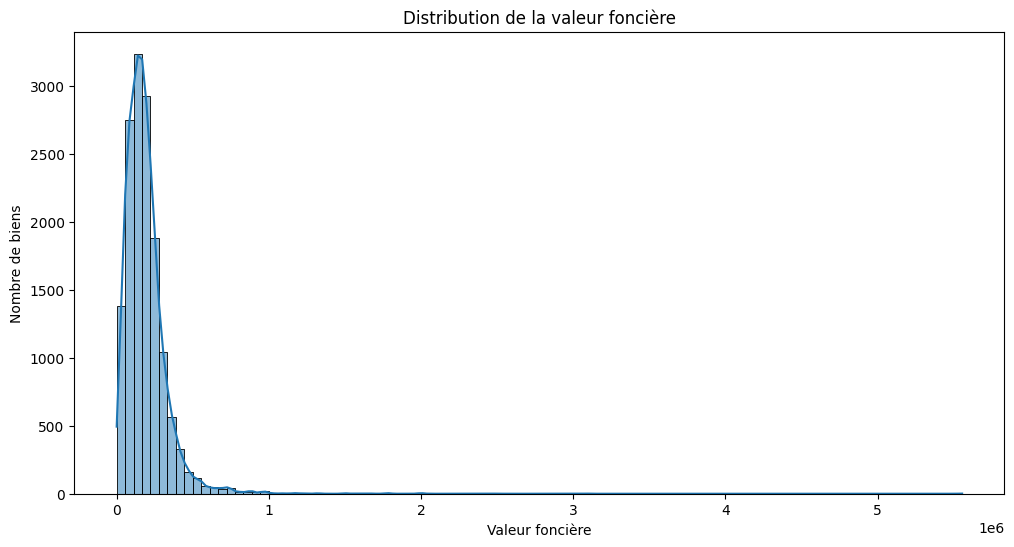

Skewness: 6.747574
Kurtosis: 155.605995


In [8]:
#valeur_fonciere

#we check the distribution of the target variable
pd.options.display.float_format = '{:.2f}'.format
print(dvf_train['valeur_fonciere'].describe())

#we plot the distribution of the target variable
plt.figure(figsize=(12, 6))
sns.histplot(dvf_train['valeur_fonciere'], bins=100, kde=True)
plt.title('Distribution de la valeur foncière')
plt.xlabel('Valeur foncière')
plt.ylabel('Nombre de biens')
plt.show()

#skewness and kurtosis
print("Skewness: %f" % dvf_train['valeur_fonciere'].skew())
print("Kurtosis: %f" % dvf_train['valeur_fonciere'].kurt())



count     14604.00
mean     187447.00
std      125346.11
min        1200.00
25%      102000.00
50%      165940.00
75%      240000.00
max     1225830.00
Name: valeur_fonciere, dtype: float64


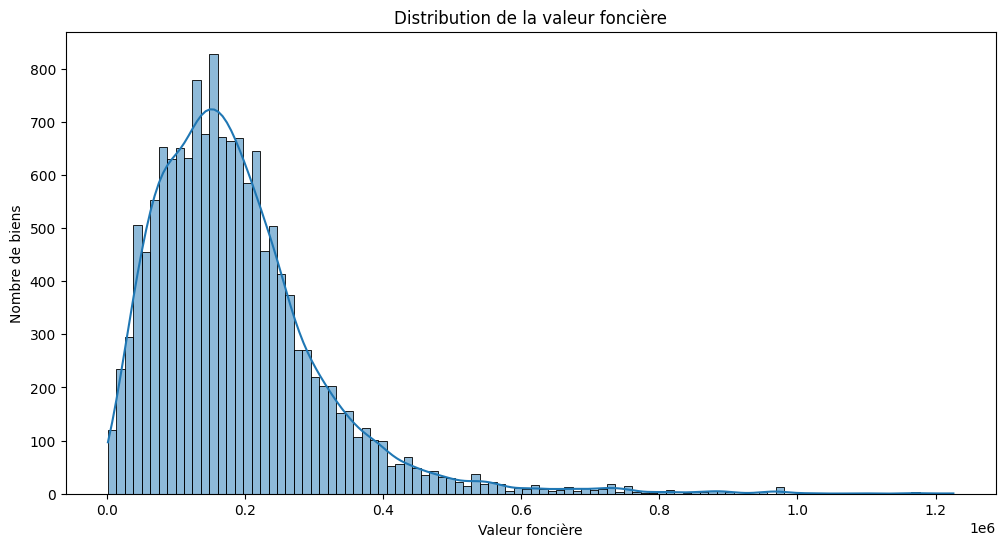

Skewness: 2.001730
Kurtosis: 7.636282


In [9]:
#we only keep the rows with a value between 1000 and 1300000
dvf_train = dvf_train[dvf_train['valeur_fonciere'] > 1000]
dvf_train = dvf_train[dvf_train['valeur_fonciere'] < 1300000]

#we check the distribution of the target variable
pd.options.display.float_format = '{:.2f}'.format
print(dvf_train['valeur_fonciere'].describe())

#we plot the distribution of the target variable
plt.figure(figsize=(12, 6))
sns.histplot(dvf_train['valeur_fonciere'], bins=100, kde=True)
plt.title('Distribution de la valeur foncière')
plt.xlabel('Valeur foncière')
plt.ylabel('Nombre de biens')
plt.show()

#skewness and kurtosis
print("Skewness: %f" % dvf_train['valeur_fonciere'].skew())
print("Kurtosis: %f" % dvf_train['valeur_fonciere'].kurt())

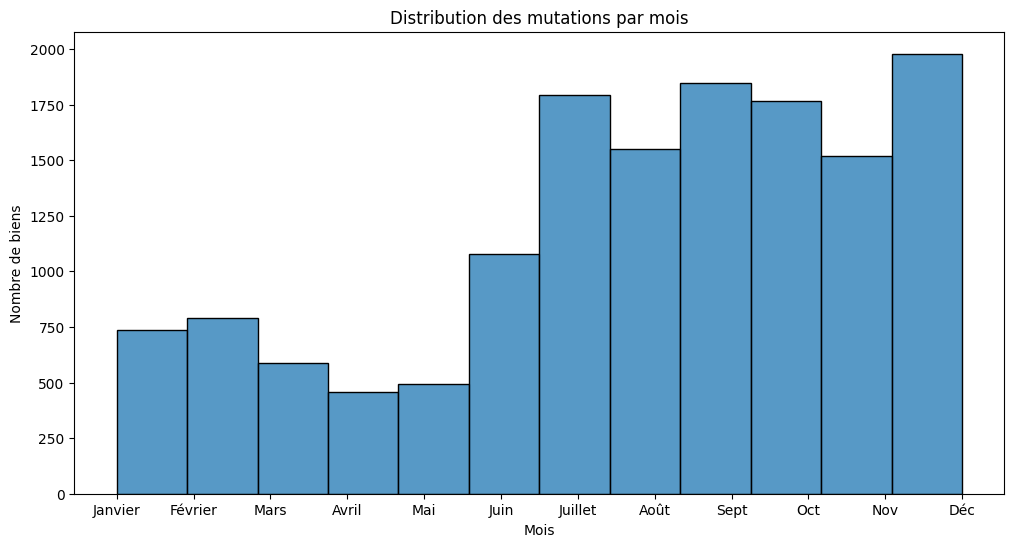

In [10]:
#we show the distribution of the month of the mutation
plt.figure(figsize=(12, 6))
sns.histplot(dvf_train['mois_mutation'], bins=12, kde=False)
mois_labels = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 'Juillet', 'Août', 'Sept', 'Oct', 'Nov', 'Déc']
plt.xticks(ticks=range(1, 13), labels=mois_labels)
plt.title('Distribution des mutations par mois')
plt.xlabel('Mois')
plt.ylabel('Nombre de biens')
plt.show()


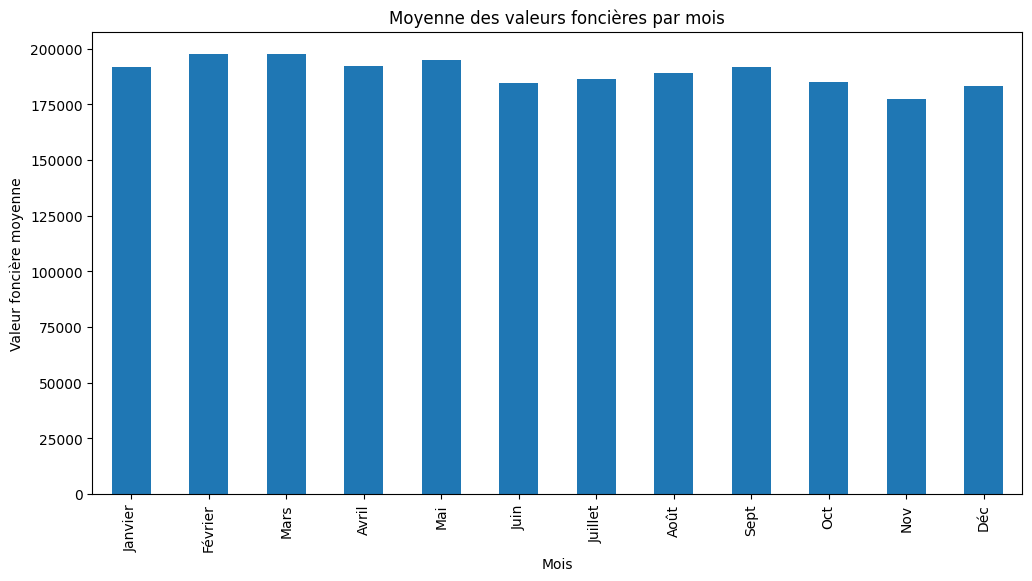

In [11]:
#we show the mean value of valeur_fonciere per month
plt.figure(figsize=(12, 6))
dvf_train.groupby('mois_mutation')['valeur_fonciere'].mean().plot(kind='bar')
plt.xticks(ticks=range(0, 12), labels=mois_labels)
plt.title('Moyenne des valeurs foncières par mois')
plt.xlabel('Mois')
plt.ylabel('Valeur foncière moyenne')
plt.show()


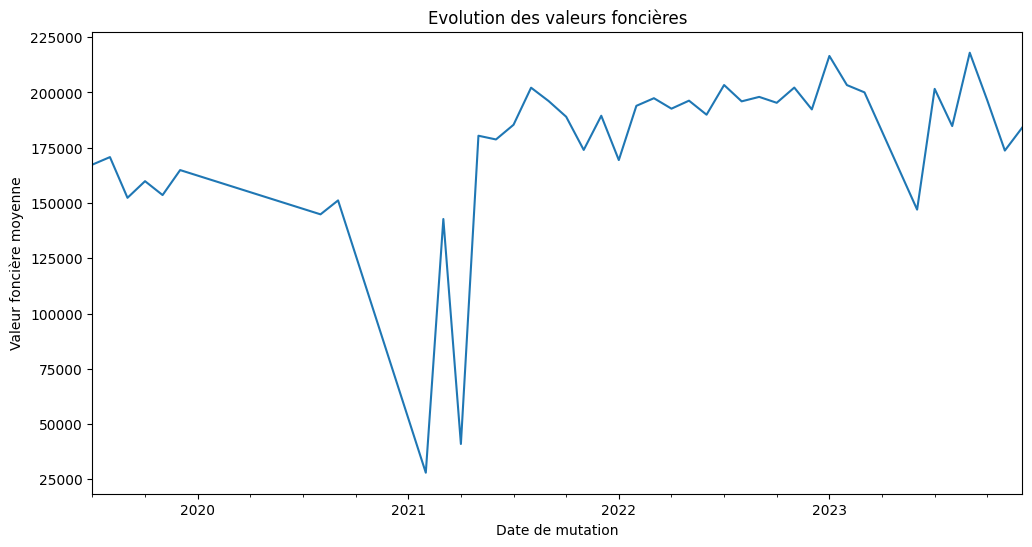

In [ ]:
#we show the evolution of the mean value of valeur_fonciere per month
plt.figure(figsize=(12, 6))
dvf_train.groupby('annee_mois_mutation')['valeur_fonciere'].mean().plot()
plt.title('Evolution des valeurs foncières')
plt.xlabel('Date de mutation')
plt.ylabel('Valeur foncière moyenne')
plt.show()


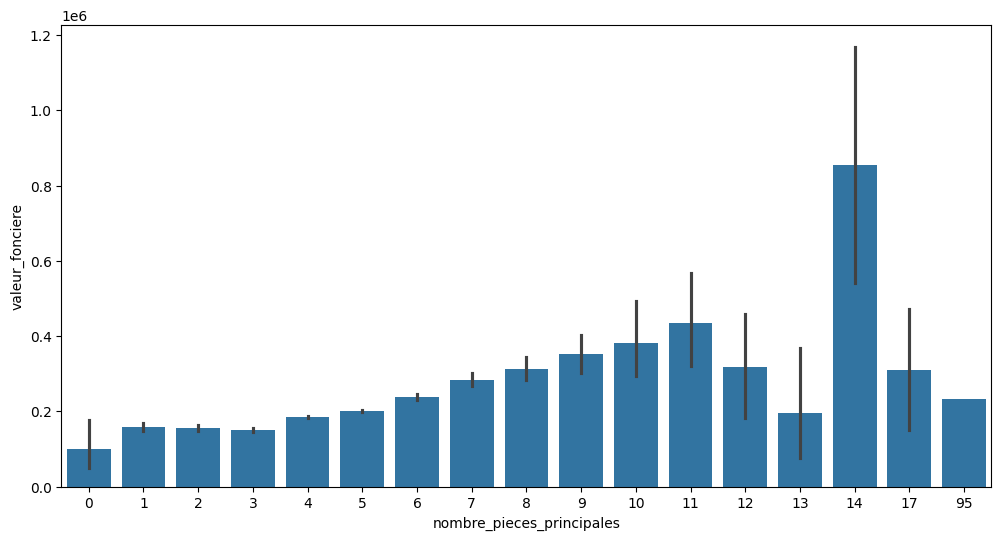

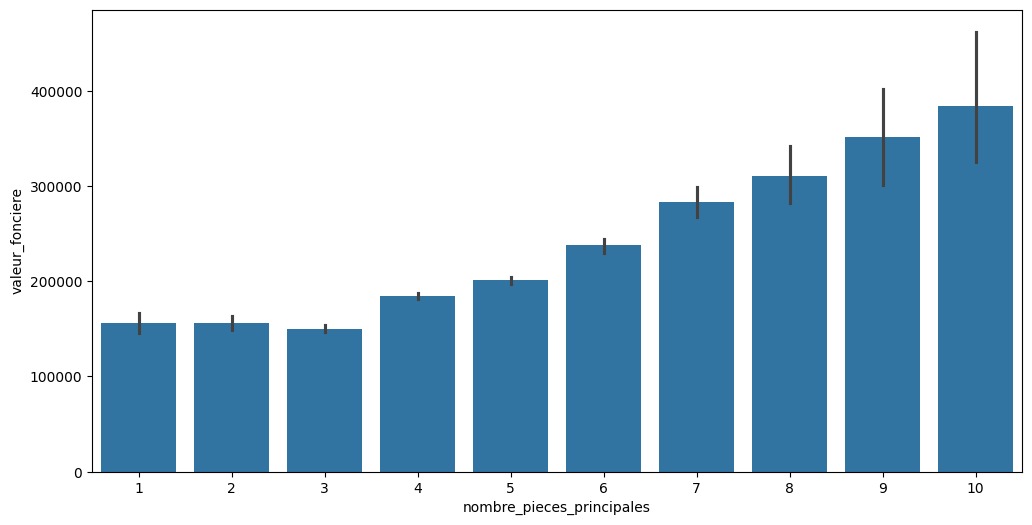

In [ ]:
#scatter plot nombre_pieces_principales/valeur_fonciere 
var = 'nombre_pieces_principales'
plt.figure(figsize=(12, 6))
sns.barplot(x='nombre_pieces_principales', y='valeur_fonciere', data=dvf_train)
plt.show()

#we group the houses with more than 10 rooms and we set the houses with 0 rooms to 1
dvf_train.loc[dvf_train['nombre_pieces_principales'] > 10, 'nombre_pieces_principales'] = 10
dvf_train.loc[dvf_train['nombre_pieces_principales'] == 0, 'nombre_pieces_principales'] = 1


plt.figure(figsize=(12, 6))
sns.barplot(x='nombre_pieces_principales', y='valeur_fonciere', data=dvf_train)
plt.show()


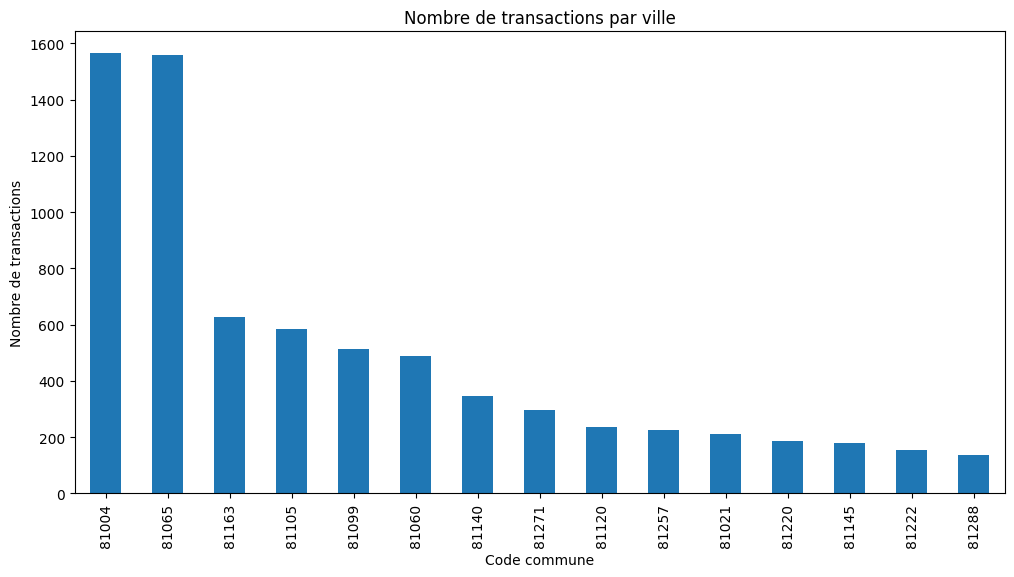

In [ ]:
#we show the cities with the most transactions
plt.figure(figsize=(12, 6))
dvf_train['code_commune'].value_counts().head(15).plot(kind='bar')
plt.title('Nombre de transactions par ville')
plt.xlabel('Code commune')
plt.ylabel('Nombre de transactions')
plt.show()

# Albi (81004) et Castres (81065)


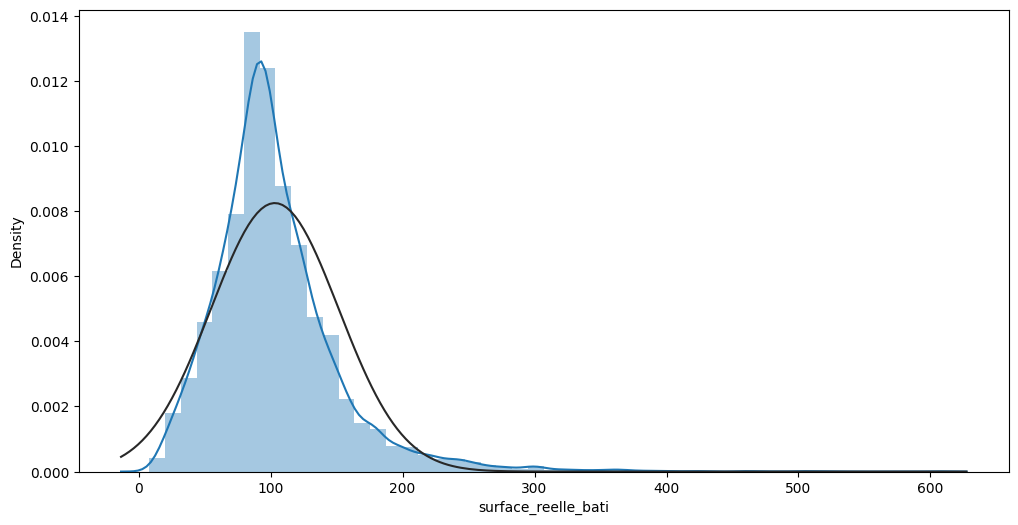

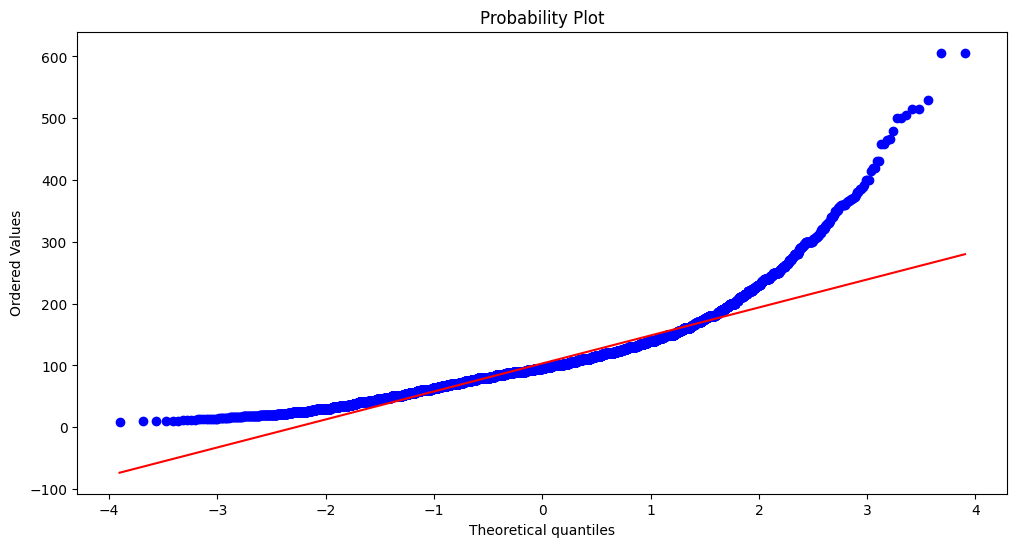

In [15]:
#histogram and normal probability plot
plt.figure(figsize=(12, 6))
sns.distplot(dvf_train['surface_reelle_bati'], fit=norm);
fig = plt.figure(figsize=(12, 6))
res = stats.probplot(dvf_train['surface_reelle_bati'], plot=plt)


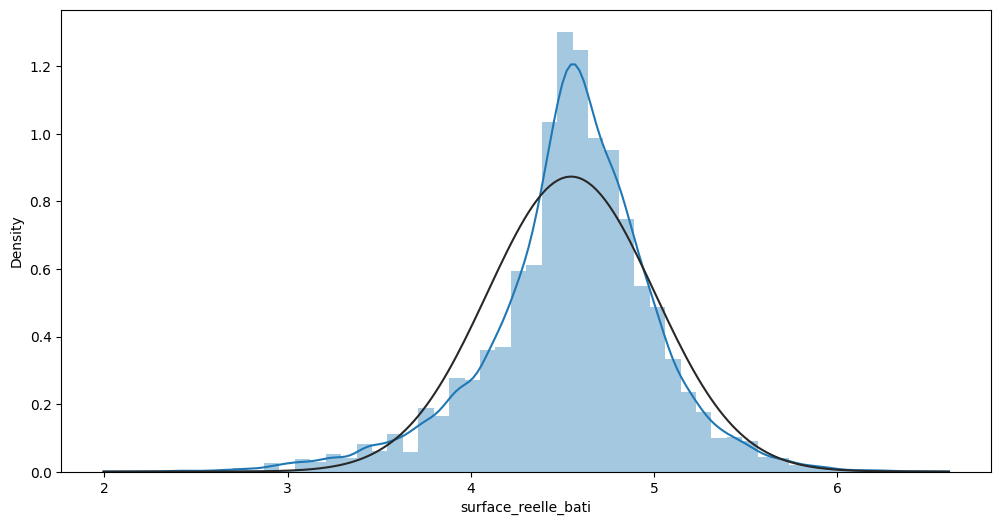

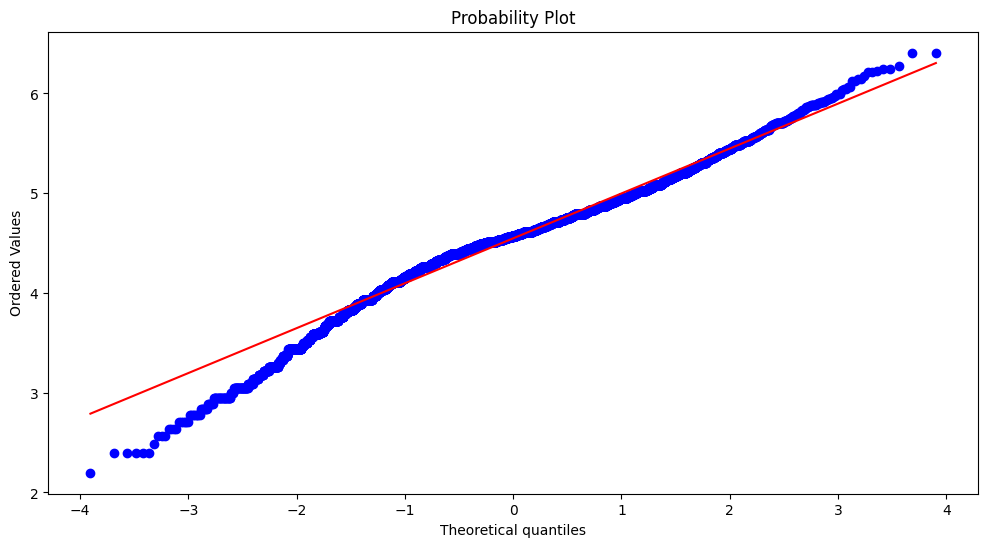

In [16]:
#applying log transformation
dvf_train = log_transform(dvf_train, 'surface_reelle_bati')

#transformed histogram and normal probability plot
plt.figure(figsize=(12, 6))
sns.distplot(dvf_train['surface_reelle_bati'], fit=norm);
fig = plt.figure(figsize=(12, 6))
res = stats.probplot(dvf_train['surface_reelle_bati'], plot=plt)

count   14604.00
mean      600.17
std       771.23
min         1.00
25%       197.00
50%       463.00
75%       739.00
max     35708.00
Name: surface_terrain, dtype: float64
Skewness: 10.712688
Kurtosis: 334.627092


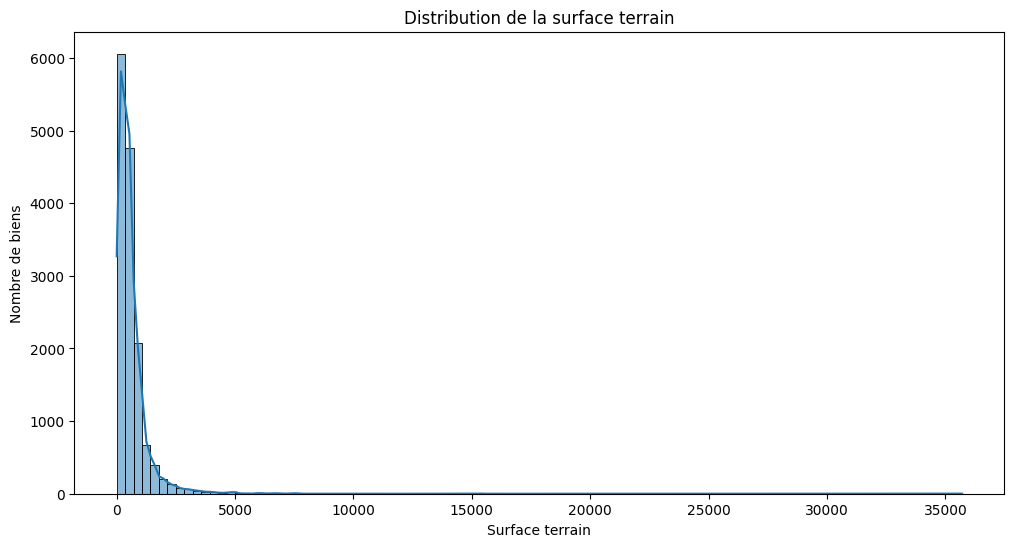

count   14604.00
mean      593.37
std       662.99
min         1.00
25%       197.00
50%       463.00
75%       739.00
max      6000.00
Name: surface_terrain, dtype: float64
Skewness: 3.647944
Kurtosis: 19.862564


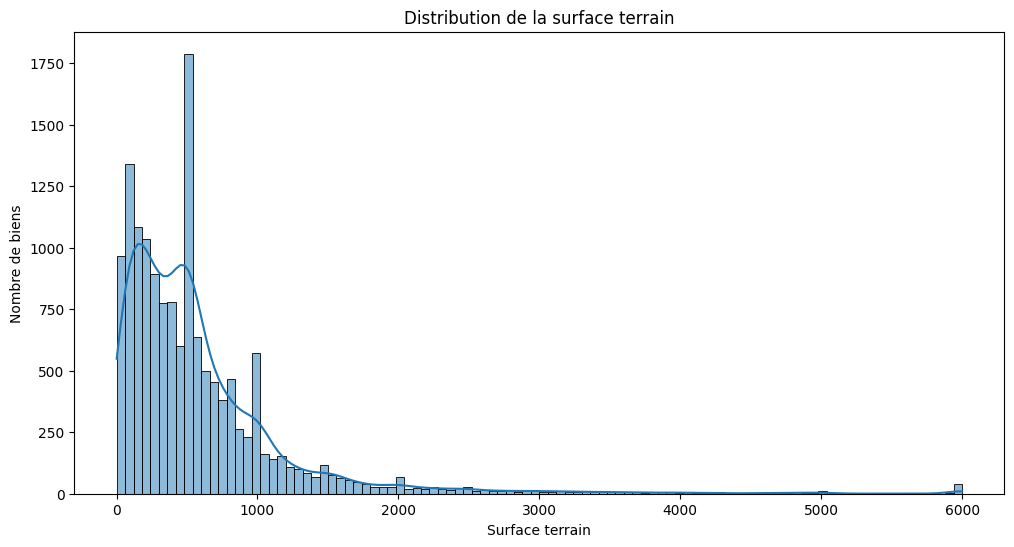

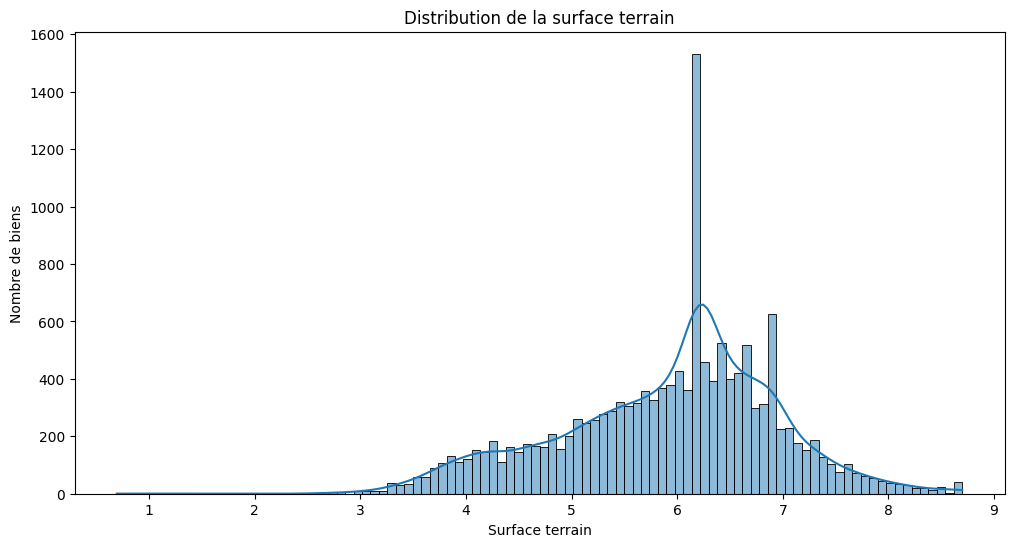

In [ ]:
#we show the distribution of the surface terrain
pd.options.display.float_format = '{:.2f}'.format
print(dvf_train['surface_terrain'].describe())
#skewness and kurtosis
print("Skewness: %f" % dvf_train['surface_terrain'].skew())
print("Kurtosis: %f" % dvf_train['surface_terrain'].kurt())

#we plot the distribution of the surface terrain
plt.figure(figsize=(12, 6))
sns.histplot(dvf_train['surface_terrain'], bins=100, kde=True)
plt.title('Distribution de la surface terrain')
plt.xlabel('Surface terrain')
plt.ylabel('Nombre de biens')
plt.show()

#we set the houses with more than 6000m² to 6000m²
dvf_train.loc[dvf_train['surface_terrain'] > 6000, 'surface_terrain'] = 6000

#skewness and kurtosis
print(dvf_train['surface_terrain'].describe())
print("Skewness: %f" % dvf_train['surface_terrain'].skew())
print("Kurtosis: %f" % dvf_train['surface_terrain'].kurt())

#we plot the distribution of the surface terrain
plt.figure(figsize=(12, 6))
sns.histplot(dvf_train['surface_terrain'], bins=100, kde=True)
plt.title('Distribution de la surface terrain')
plt.xlabel('Surface terrain')
plt.ylabel('Nombre de biens')
plt.show()


dvf_train = log_transform(dvf_train, 'surface_terrain')
plt.figure(figsize=(12, 6))
sns.histplot(dvf_train['surface_terrain'], bins=100, kde=True)
plt.title('Distribution de la surface terrain')
plt.xlabel('Surface terrain')
plt.ylabel('Nombre de biens')
plt.show()



## Clustering

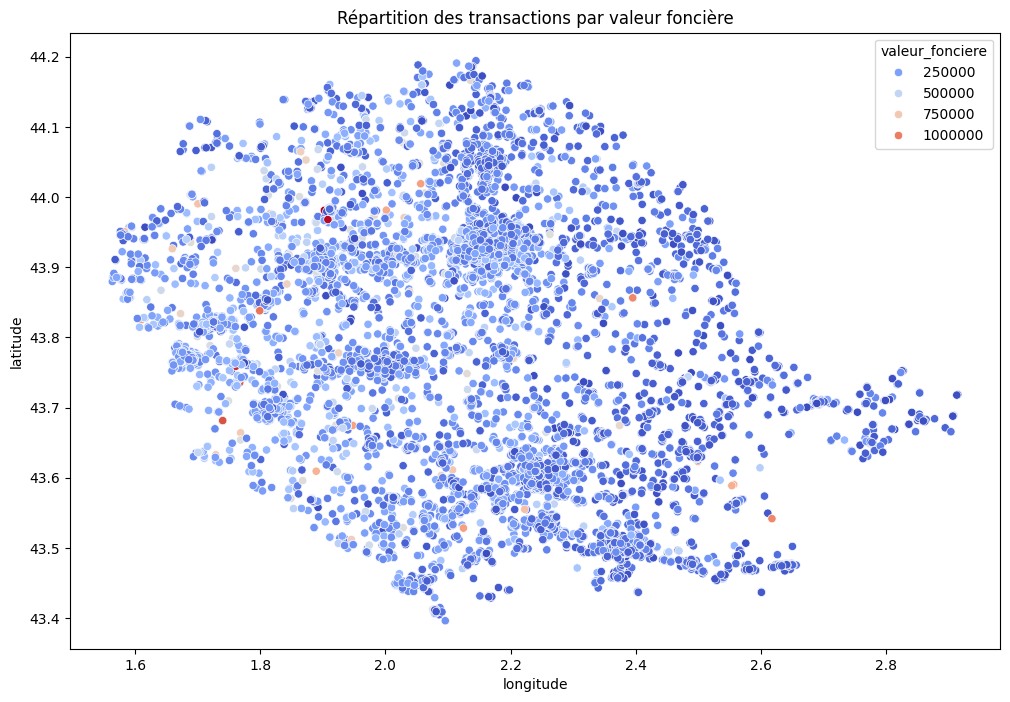

In [18]:
plt.figure(figsize=(12, 8))

sns.scatterplot(x='longitude', y='latitude', hue='valeur_fonciere', data=dvf_train, palette='coolwarm')
plt.title('Répartition des transactions par valeur foncière')
plt.show()

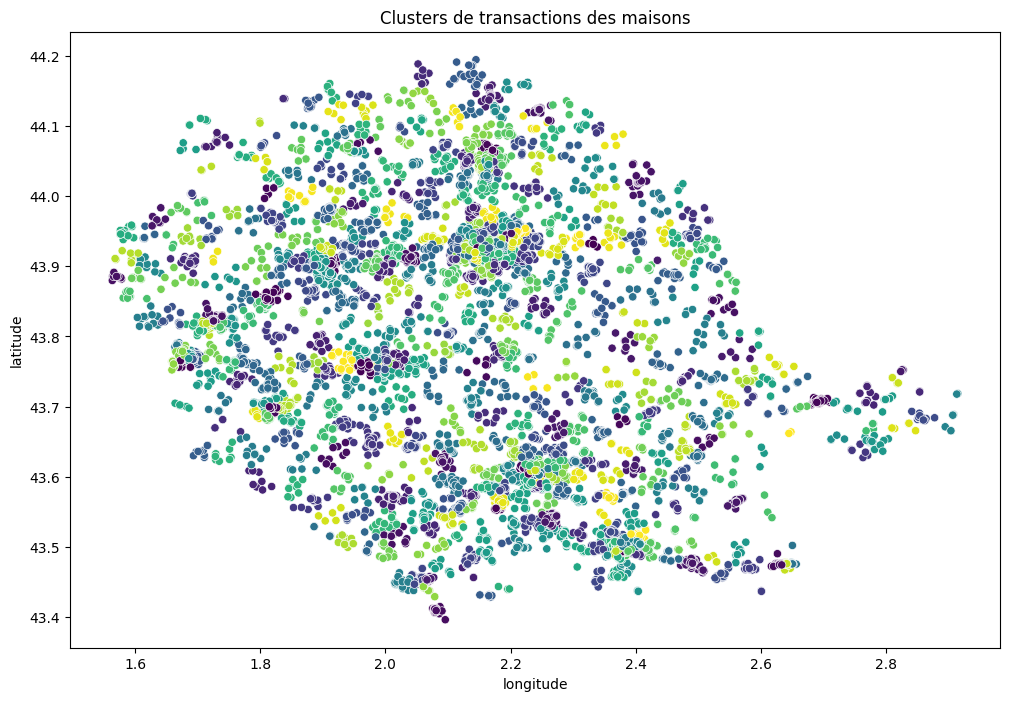

In [44]:
#we generate the clusters with kmeans
dvf_train = perform_kmeans_clustering(dvf_train, ['longitude', 'latitude'], n_clusters=500)

#we plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='longitude', y='latitude', hue='cluster', data=dvf_train, palette='viridis')
plt.title('Clusters de transactions des maisons')
plt.legend([],[], frameon=False)
plt.show()



In [45]:

dvf_train_final = dvf_train[[
    'valeur_fonciere',

    'code_type_local',
    'code_commune',
    'nombre_pieces_principales',
    'surface_reelle_bati',
    'surface_terrain',
    'surface_jardins',
    'surface_terres',
    'surface_terrain_agrement',
    'surface_terrain_autre',
    'mois_mutation',
    
    # insee
    'diplome',
    'niveau_vie',
    'taux_activite',
    'medecin',
    'ecole',
    'transport_commun',
    # computed
    'cluster',
]]




## Models benchmark

In [49]:
#we compare different models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer

models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    BaggingRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    SVR(),
    KNeighborsRegressor(),
]

X_train, X_test, y_train, y_test = train_test_split(dvf_train_final.drop(
    ['valeur_fonciere'], axis=1), dvf_train_final['valeur_fonciere'], test_size=0.20, random_state=42)

# we create an imputer
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

model_result = [] 

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred)
    model_result.append((model, accuracy, mse))
    
model_result.sort(key=lambda x: x[2])

for model, accuracy, mse in model_result:
    #accuracy arrondi à 2 chiffres
    print(f'{model} - Accuracy: {round(accuracy * 100,2)} - MSE: {mse}')


ExtraTreesRegressor() - Accuracy: 60.76 - MSE: 6648568549.762251
RandomForestRegressor() - Accuracy: 59.65 - MSE: 6836301582.914529
BaggingRegressor() - Accuracy: 55.71 - MSE: 7503775842.638199
GradientBoostingRegressor() - Accuracy: 53.45 - MSE: 7886597688.011902
LinearRegression() - Accuracy: 38.58 - MSE: 10406280384.407598
KNeighborsRegressor() - Accuracy: 36.41 - MSE: 10774100836.933914
DecisionTreeRegressor() - Accuracy: 22.61 - MSE: 13112368910.711245
AdaBoostRegressor() - Accuracy: 14.07 - MSE: 14558803484.017519
SVR() - Accuracy: -4.15 - MSE: 17645638225.496628


## RandomForestRegressor

Précision du modèle : 0.6003867925542679
Erreur quadratique moyenne : 6770605127.039571


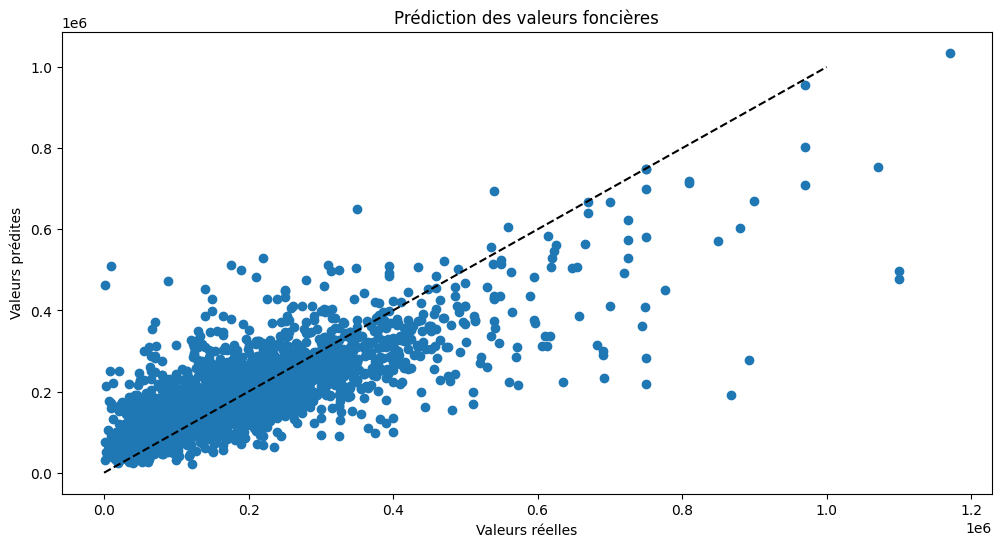

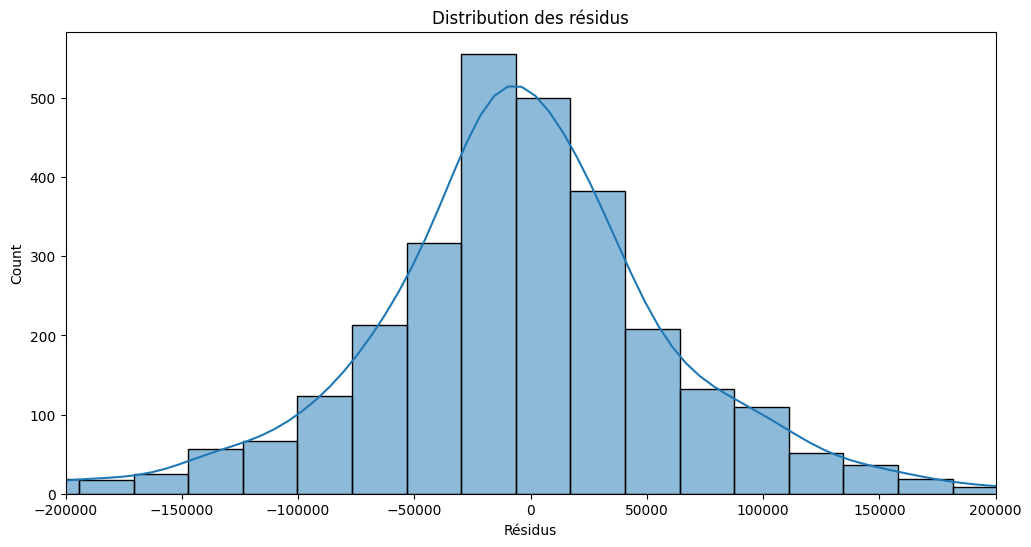

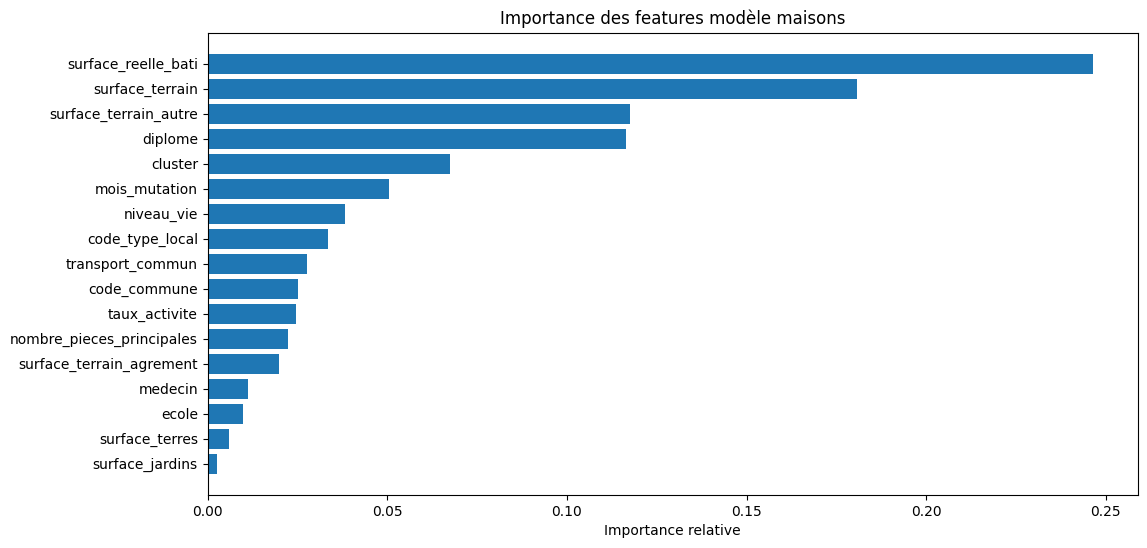

In [50]:
X_train, X_test, y_train, y_test = train_test_split(dvf_train_final.drop(
    ['valeur_fonciere'], axis=1), dvf_train_final['valeur_fonciere'], test_size=0.20, random_state=42)

rf = RandomForestRegressor(n_estimators=950, random_state=42)
rf.fit(X_train, y_train)

#prediction
y_pred = rf.predict(X_test)

#we evaluate the model
accuracy = rf.score(X_test, y_test)
print('Précision du modèle :', accuracy)

#we calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Erreur quadratique moyenne :', mse)

#we plot the real values against the predicted values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred)
plt.plot([0, 1000000], [0, 1000000], '--k')
plt.title('Prédiction des valeurs foncières')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.show()


#we plot the distribution of the residuals
plt.figure(figsize=(12, 6))
sns.histplot(y_test - y_pred, bins=50, kde=True)
plt.xlim(-200000, 200000)
plt.title('Distribution des résidus')
plt.xlabel('Résidus')
plt.show()

#we plot the importance of the features
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 6))
plt.title('Importance des features modèle maisons')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importance relative')
plt.show()

## ExtraTreesRegressor

Précision du modèle : 0.6112408120826945
Erreur quadratique moyenne : 6586706599.916609


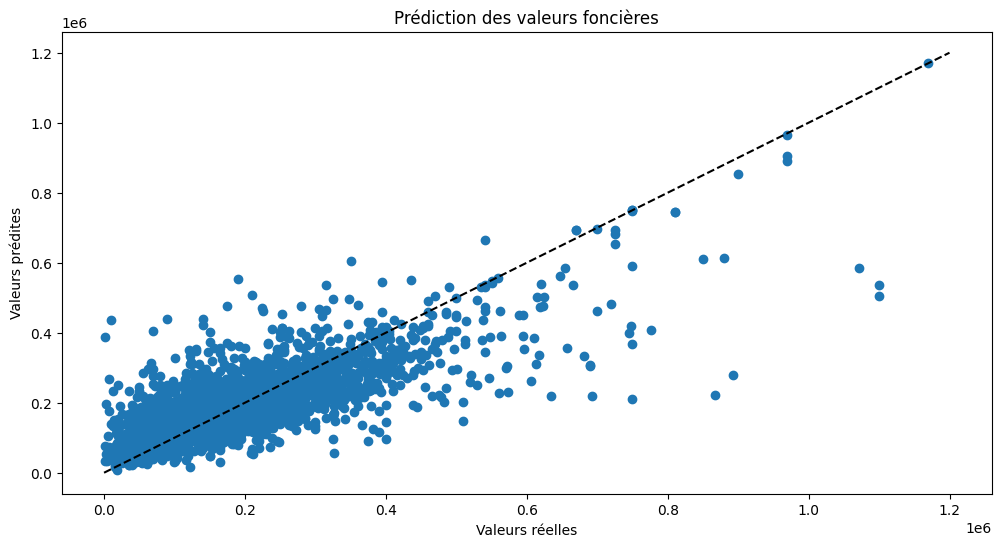

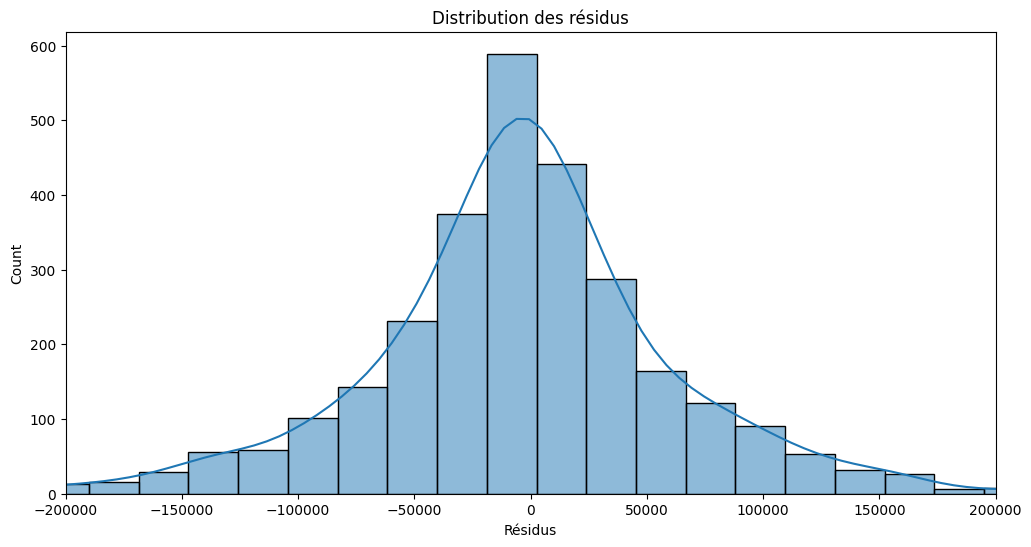

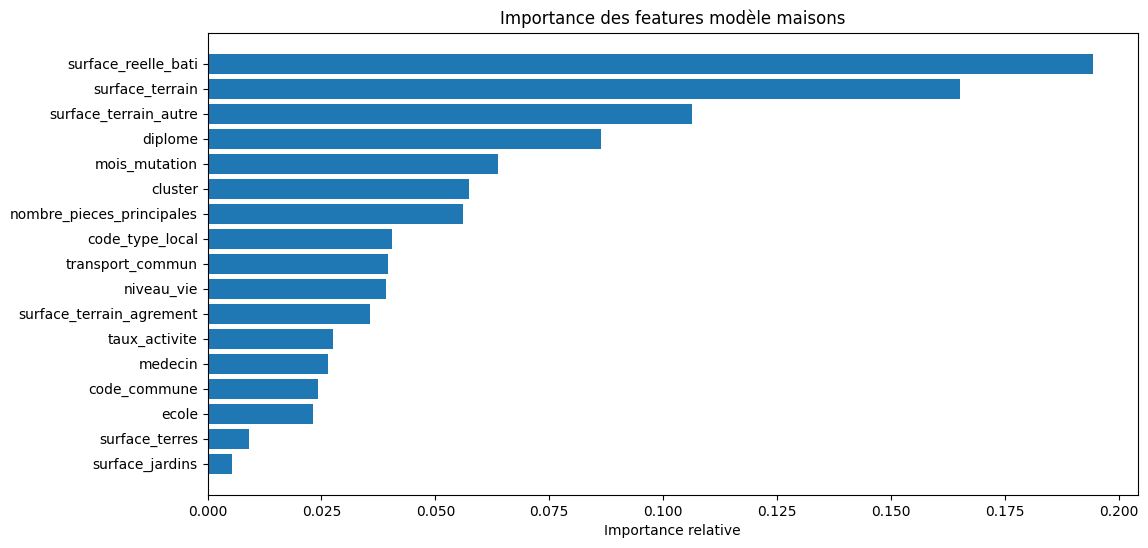

In [51]:
X_train, X_test, y_train, y_test = train_test_split(dvf_train_final.drop(
    ['valeur_fonciere'], axis=1), dvf_train_final['valeur_fonciere'], test_size=0.20, random_state=42)

rf = ExtraTreesRegressor(n_estimators=1000, random_state=42)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

#we evaluate the model
accuracy = rf.score(X_test, y_test)
print('Précision du modèle :', accuracy)

#we calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Erreur quadratique moyenne :', mse)

#we plot the real values against the predicted values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred)
plt.plot([0, 1200000], [0, 1200000], '--k')
plt.title('Prédiction des valeurs foncières')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.show()


#we plot the distribution of the residuals
plt.figure(figsize=(12, 6))
sns.histplot(y_test - y_pred, bins=50, kde=True)
plt.xlim(-200000, 200000)
plt.title('Distribution des résidus')
plt.xlabel('Résidus')
plt.show()

#we plot the importance of the features
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 6))
plt.title('Importance des features modèle maisons')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importance relative')
plt.show()